In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import Ridge, Lasso, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
import shap

In [2]:
#Leitura dos dados e verificação dos cabeçalhos e 2 primeiras linhas
df=pd.read_excel('DADOS_TESTE_R02.xlsx',usecols='B:U',skiprows=1)
df.head(2)

,Exp,Temp Med (°C),Temp Min (°C),Temp Max (°C),Temp Dpad,Precip Acum Mensal (mm),UR Med (%),UR. Min. (%),UR. Max. (%),UR Dpad,Vento Med (m/s),Vento Min (m/s),Vento Max (m/s),Vento Dpad,Direção Pred. Vento (°),Terral0|Maral1,Dist Mar (m),Outra Fonte (N0|S1),Densi. Obstáculos (0|1|2),Dep Cl (mg/m²)
0,VER,26.45,22.6,30.3,3.85,110.0,84.254672,70.250000,87.5,8.625000,4.845013,1.173696,8.516331,3.671317,90.0,1,35,0,1,523.34
1,OUT,21.25,16.9,25.6,4.35,49.0,77.646633,71.993267,83.3,5.653367,4.542106,0.487919,8.596294,4.054187,45.0,1,35,0,1,404.07


#### Exploração dos dados

In [3]:
#Verificação dos tipos de dados
df.dtypes

Exp                           object
Temp Med (°C)                float64
Temp Min (°C)                float64
Temp Max (°C)                float64
Temp Dpad                    float64
Precip Acum Mensal (mm)      float64
UR Med (%)                   float64
UR. Min. (%)                 float64
UR. Max. (%)                 float64
UR Dpad                      float64
Vento Med (m/s)              float64
Vento Min (m/s)              float64
Vento Max (m/s)              float64
Vento Dpad                   float64
Direção Pred. Vento (°)      float64
Terral0|Maral1                 int64
Dist Mar (m)                   int64
Outra Fonte (N0|S1)            int64
Densi. Obstáculos (0|1|2)      int64
Dep Cl (mg/m²)                object
dtype: object

In [4]:
#Tem algo estranho com os dados de deposição, já que deveria ser do tipo float.

In [5]:
#Remove as colunas com valores de desvio padrão
cols=['Temp Dpad','Vento Dpad']
df=df.drop(cols,axis=1)

In [6]:
#Converte os nomes dos meses do ano em números, com base nas estações do ano: verão-1, outono-2, inverno-3, primavera-4
df_cp=df.copy()  #Cria uma copia para evitar erros
dict_mes = {
    'JAN': 1, 'FEV': 1, 'MAR': 2, 'ABR': 2, 'MAI': 2, 'JUN': 3, 
    'JUL': 3, 'AGO': 3, 'SET': 4, 'OUT': 4, 'NOV': 4, 'DEZ': 1,
    'VER':1,'OUT':2,'INV':3,'PRI':4    
}
df_cp['Exp'] = df_cp['Exp'].map(dict_mes)     
df_cp['Exp'].head(5)

0    1
1    2
2    3
3    4
4    1
Name: Exp, dtype: int64

In [7]:
#Verificacao de dados faltantes:
df_cp.isnull().mean()*100

Exp                          0.000000
Temp Med (°C)                0.000000
Temp Min (°C)                0.000000
Temp Max (°C)                0.000000
Precip Acum Mensal (mm)      0.000000
UR Med (%)                   0.000000
UR. Min. (%)                 0.000000
UR. Max. (%)                 0.000000
UR Dpad                      0.000000
Vento Med (m/s)              0.000000
Vento Min (m/s)              0.000000
Vento Max (m/s)              0.000000
Direção Pred. Vento (°)      0.000000
Terral0|Maral1               0.000000
Dist Mar (m)                 0.000000
Outra Fonte (N0|S1)          0.000000
Densi. Obstáculos (0|1|2)    0.000000
Dep Cl (mg/m²)               0.342466
dtype: float64

In [8]:
#Como pode ser visto acima, existem dados faltantes na variável target. Como a quantidade é pequena, estes serão eliminados.
#1 - elimina linhas com dados faltantes
df_cp=df_cp.dropna()
#2 -Elimina linhas que estão preenchidas com strings na coluna de deposição de cloreto (target):
df_cp =df_cp[~df_cp.iloc[:,-1].apply(lambda x: isinstance(x, str))]

In [9]:
df_cp.isnull().mean()*100

Exp                          0.0
Temp Med (°C)                0.0
Temp Min (°C)                0.0
Temp Max (°C)                0.0
Precip Acum Mensal (mm)      0.0
UR Med (%)                   0.0
UR. Min. (%)                 0.0
UR. Max. (%)                 0.0
UR Dpad                      0.0
Vento Med (m/s)              0.0
Vento Min (m/s)              0.0
Vento Max (m/s)              0.0
Direção Pred. Vento (°)      0.0
Terral0|Maral1               0.0
Dist Mar (m)                 0.0
Outra Fonte (N0|S1)          0.0
Densi. Obstáculos (0|1|2)    0.0
Dep Cl (mg/m²)               0.0
dtype: float64

In [10]:
#Convert os dados da última coluna para float
df_cp.iloc[:,-1]=df_cp.iloc[:,-1].astype(float)

In [11]:
#Verifica as estatisticas do dataframe
df_cp.describe()

,Exp,Temp Med (°C),Temp Min (°C),Temp Max (°C),Precip Acum Mensal (mm),UR Med (%),UR. Min. (%),UR. Max. (%),UR Dpad,Vento Med (m/s),Vento Min (m/s),Vento Max (m/s),Direção Pred. Vento (°),Terral0|Maral1,Dist Mar (m),Outra Fonte (N0|S1),Densi. Obstáculos (0|1|2),Dep Cl (mg/m²)
count,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.00000,274.000000
mean,2.332117,26.550365,22.633577,30.467153,76.664964,70.955012,68.010698,73.626277,2.807789,4.722709,2.546714,6.898704,101.257299,0.529197,2107.992701,0.233577,1.60219,324.199176
std,1.017750,1.334441,1.160162,2.027760,96.985672,6.007017,5.446784,5.974320,1.432533,1.203635,0.768035,2.191860,17.760836,0.500060,2470.922842,0.423880,0.68377,693.166939
min,1.000000,21.250000,16.900000,22.200000,2.200000,58.000000,55.000000,62.000000,1.250000,2.000000,0.487919,1.200000,45.000000,0.000000,35.000000,0.000000,0.00000,5.155400
25%,2.000000,26.475000,22.200000,30.500000,8.200000,69.000000,67.000000,71.000000,2.000000,4.050000,1.900000,5.900000,101.000000,0.000000,250.000000,0.000000,1.00000,62.678125
50%,2.000000,26.750000,22.500000,31.200000,10.800000,71.000000,68.000000,72.000000,2.500000,5.000000,2.800000,7.400000,105.000000,1.000000,1000.000000,0.000000,2.00000,119.930100
75%,3.000000,27.050000,23.500000,31.500000,111.400000,76.000000,71.000000,78.000000,3.250000,5.787836,3.000000,8.512248,108.000000,1.000000,4000.000000,0.000000,2.00000,245.173825
max,4.000000,27.650000,23.800000,31.900000,294.800000,84.254672,74.500000,87.500000,8.625000,6.100000,3.600000,10.225669,123.500000,1.000000,8000.000000,1.000000,2.00000,5285.062500


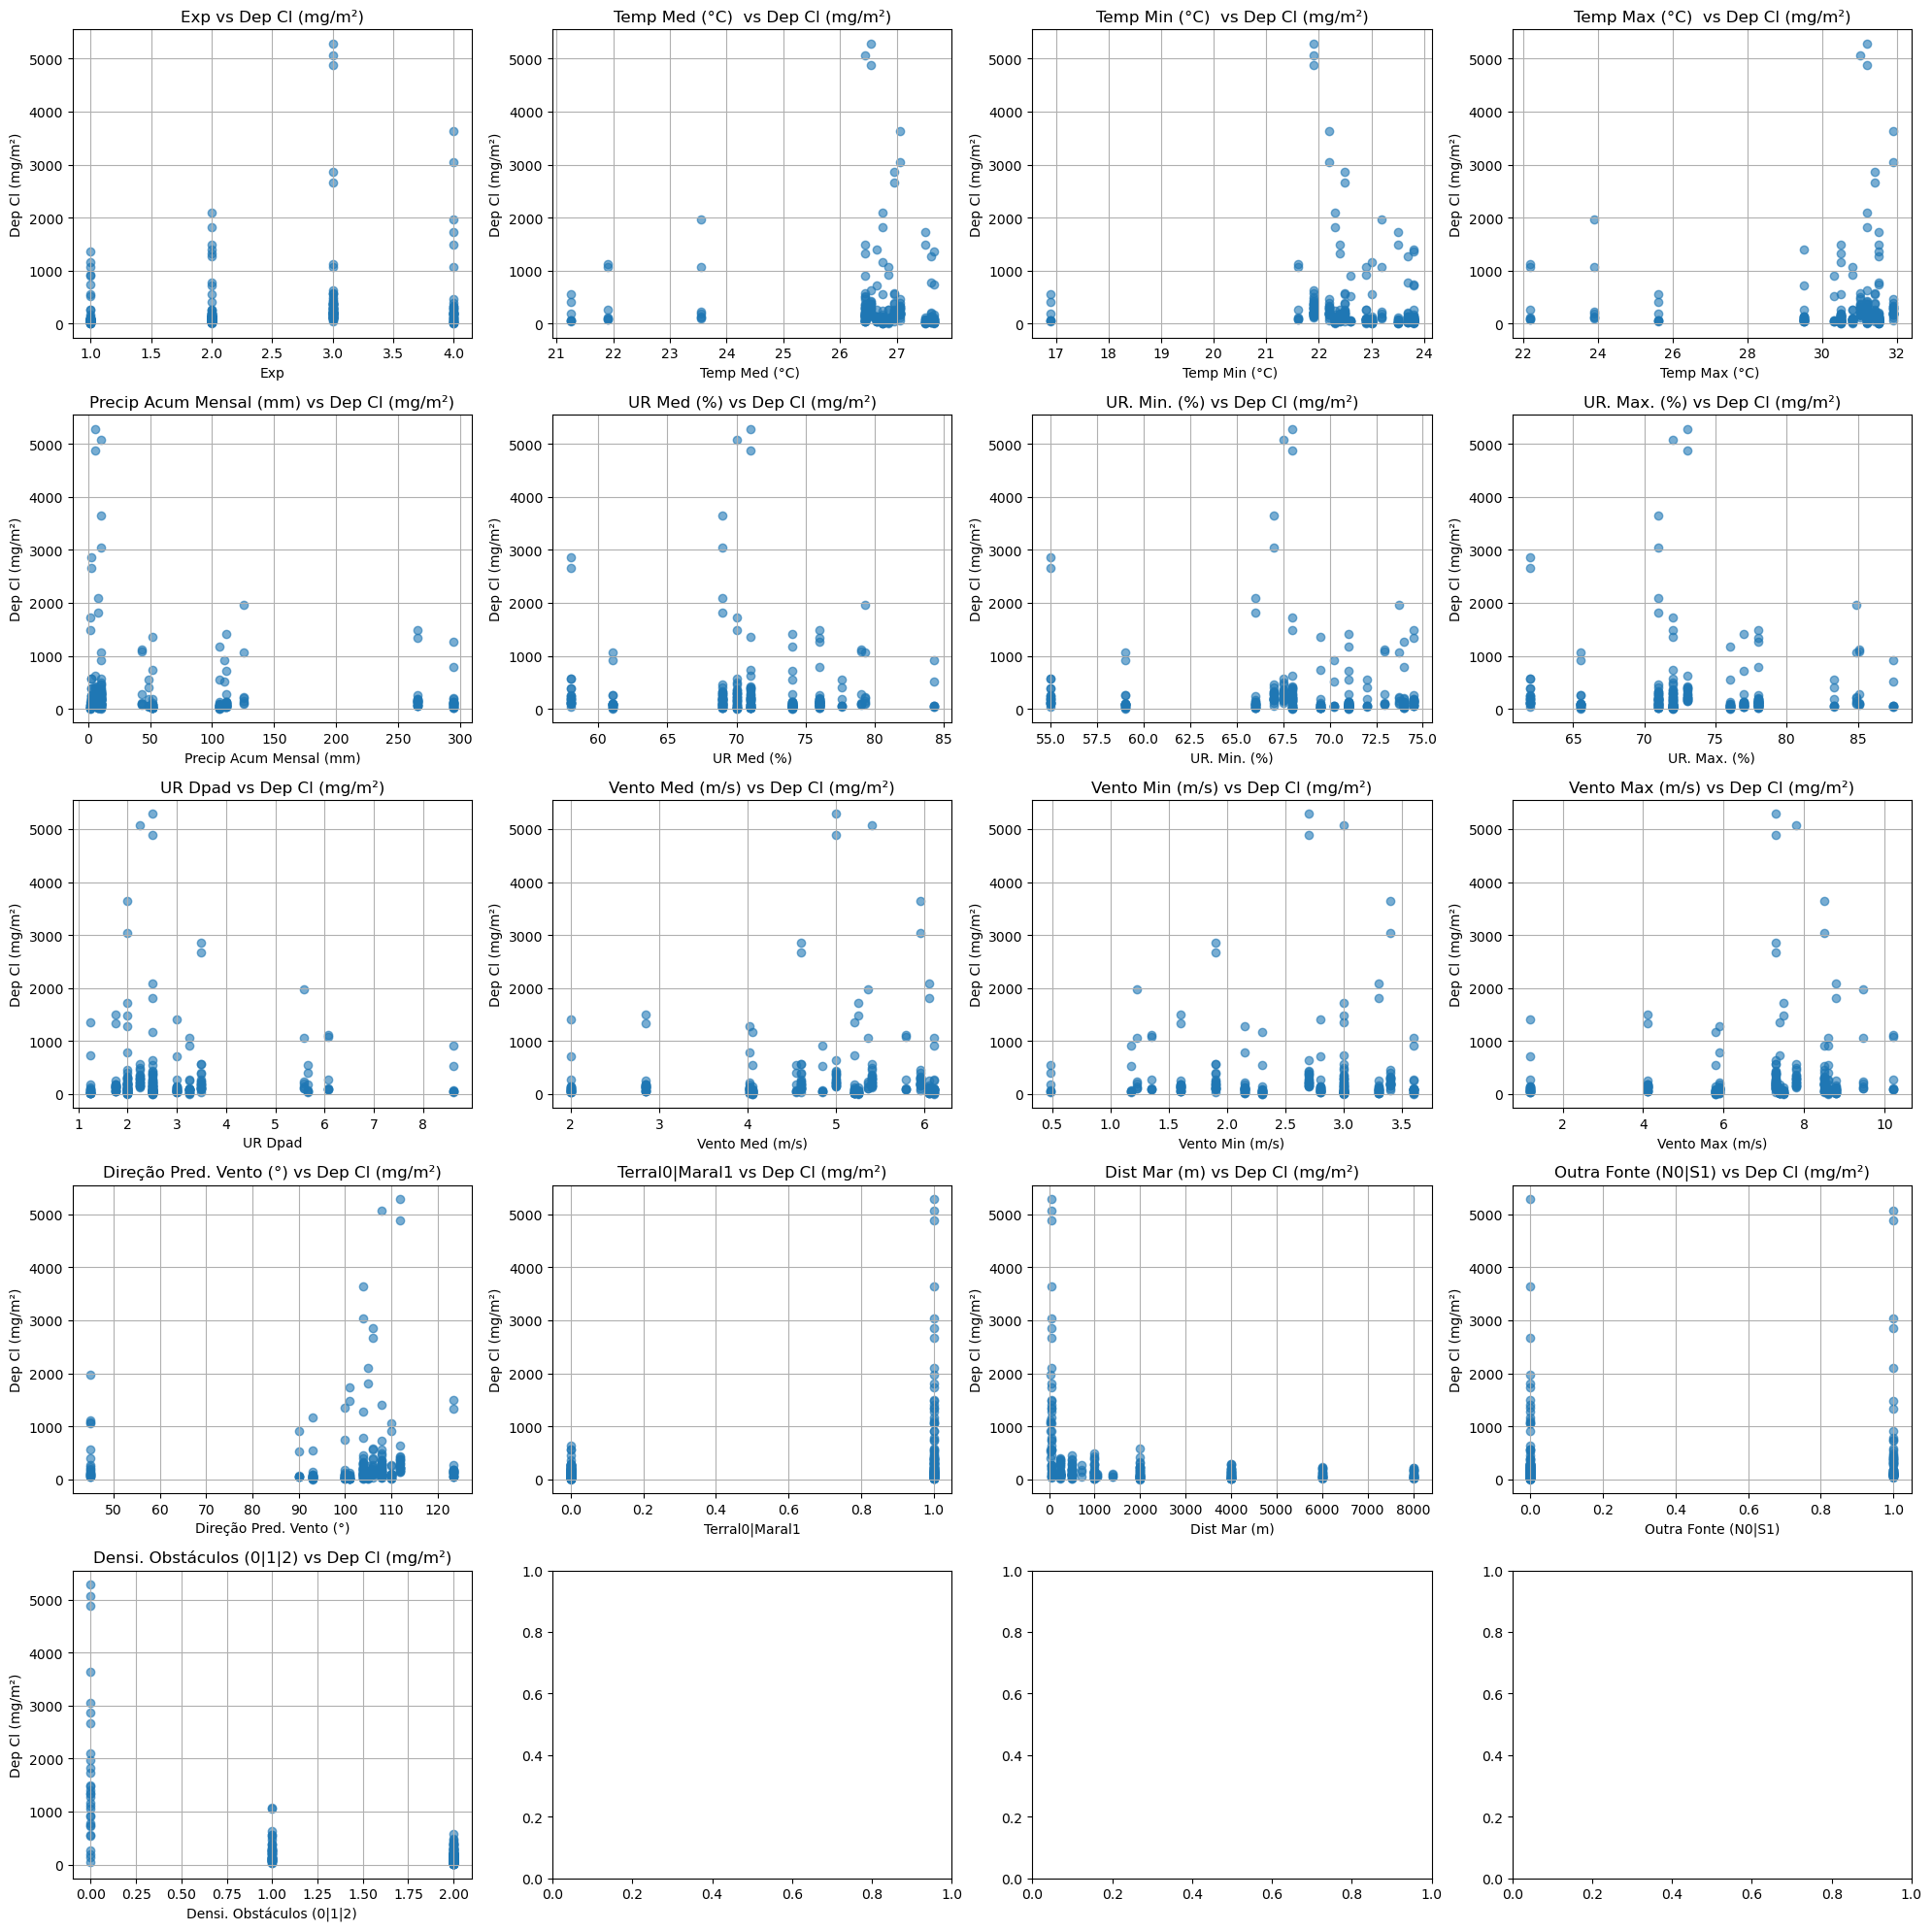

In [12]:
#Plot das relações entre variáveis independentes x target:
target = df_cp.columns[-1]
features = df_cp.columns[:-1]
n_cols = 4
n_rows = 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))
axes = axes.flatten()
for i, col in enumerate(features):
    axes[i].scatter(df_cp[col], df_cp[target], alpha=0.6)
    axes[i].set_title(f"{col} vs {target}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel(target)
    axes[i].grid(True)
plt.tight_layout()
plt.show()

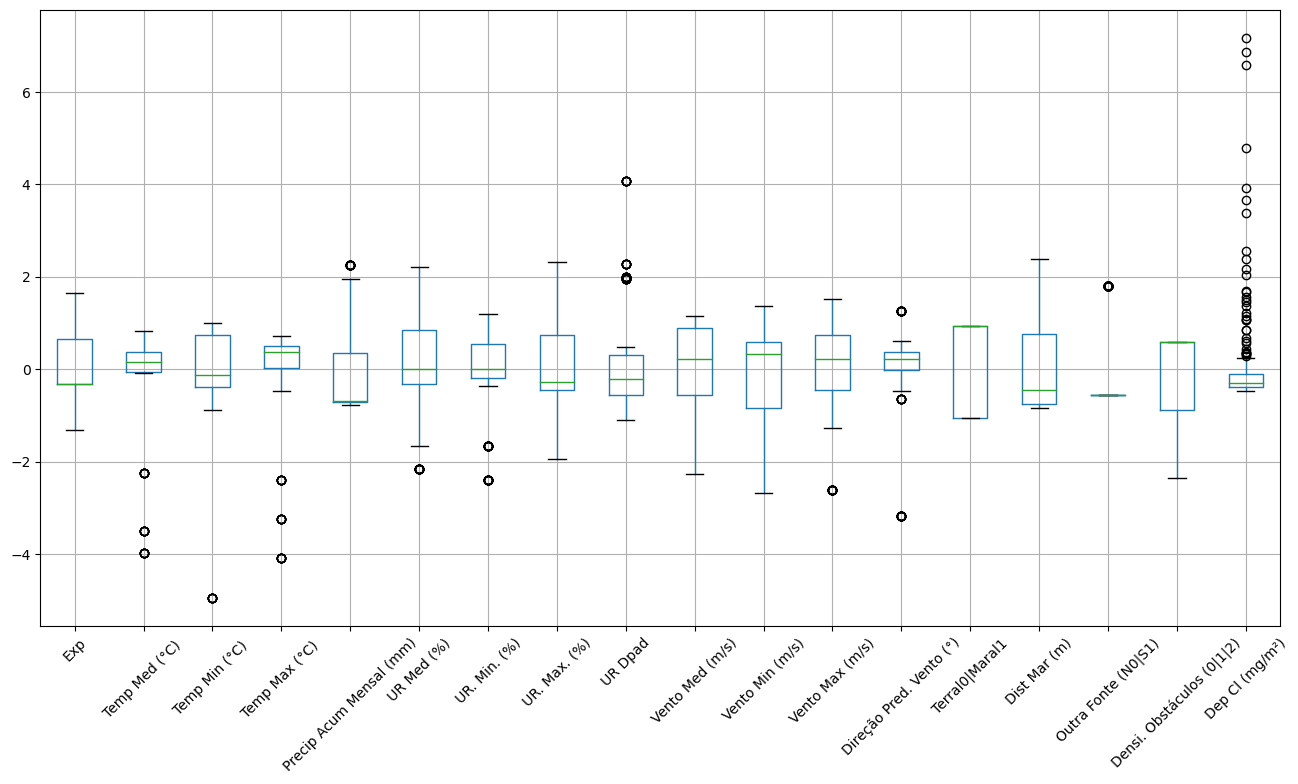

In [13]:
#Verificação de outliers em cada variável usando boxplots
std=StandardScaler()
scaler = StandardScaler()
temp=scaler.fit_transform(df_cp)
temp=pd.DataFrame(temp,columns=df_cp.columns)
#Plota o boxplot
plt.figure(figsize=(16,8))
temp.boxplot(rot=45)
plt.show()

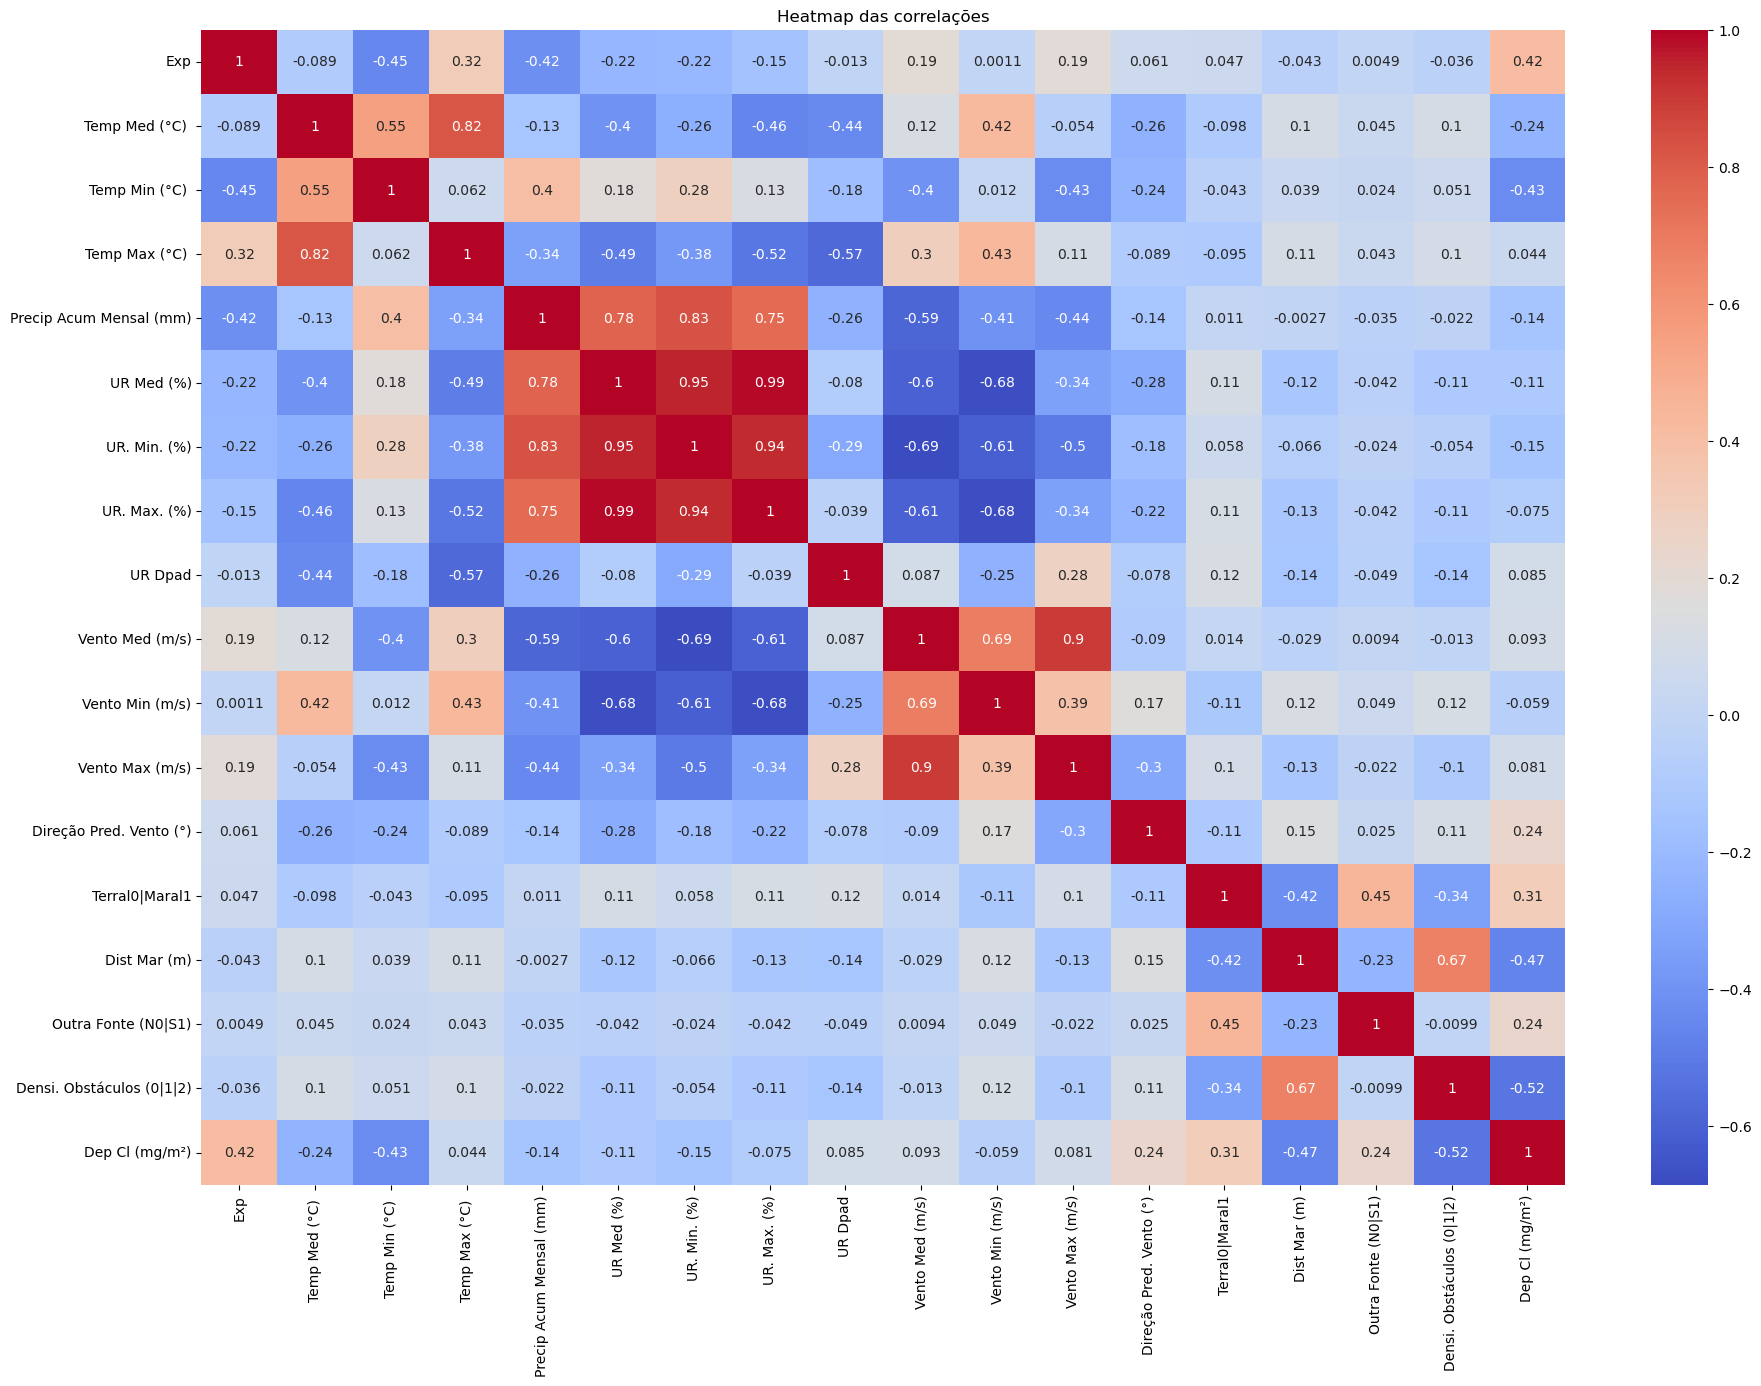

In [14]:
#Verificação das correlações:
corr=df_cp.corr(method='spearman')
plt.figure(figsize=(22,15))
sns.heatmap(corr,annot=True,cmap='coolwarm')
plt.title('Heatmap das correlações')
plt.show()

In [15]:
#Lista variáveis com correlação superior a 90%
corr_abs=corr.abs()
upper_triangle = np.triu(np.ones(corr_abs.shape), k=1).astype(bool)
list_corr = corr_abs.where(upper_triangle).stack()
high_corr = list_corr[list_corr > 0.90].sort_values(ascending=False)
print(high_corr)

UR Med (%)       UR. Max. (%)       0.992104
                 UR. Min. (%)       0.950436
UR. Min. (%)     UR. Max. (%)       0.937843
Vento Med (m/s)  Vento Max (m/s)    0.901067
dtype: float64


In [16]:
#Eliminação dos dados com correlações acima de 90%:
corr = df_cp.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
print(to_drop)
df_filt = df_cp.drop(columns=to_drop)

['Temp Max (°C) ', 'UR. Min. (%)', 'UR. Max. (%)', 'Vento Max (m/s)']


In [17]:
#Padronização
X=df_filt.iloc[:,:-1]
y=df_filt.iloc[:,-1]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [18]:
#Divisão treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Melhor número de atributos: 12
Atributos selecionados: ['Exp', 'Temp Med (°C) ', 'Temp Min (°C) ', 'Precip Acum Mensal (mm)', 'UR Med (%)', 'Vento Med (m/s)', 'Vento Min (m/s)', 'Direção Pred. Vento (°)', 'Terral0|Maral1', 'Dist Mar (m)', 'Outra Fonte (N0|S1)', 'Densi. Obstáculos (0|1|2)']


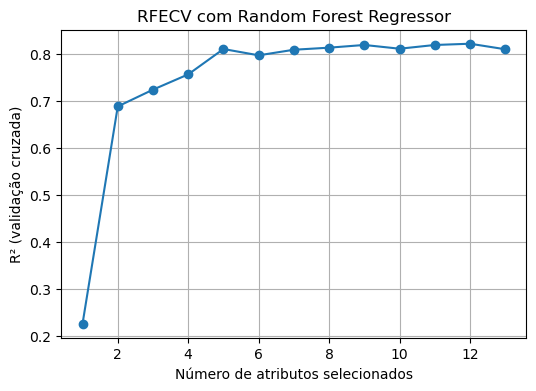

In [71]:
#Verificação das variáveis mais importantes com a eliminação recursiva de atributos (RFE):
def RFE(x,y):
    model=RandomForestRegressor(n_estimators=100, random_state=50)
    cv = KFold(n_splits=5, shuffle=True, random_state=50)
    rfecv = RFECV(estimator=model, step=1, cv=cv, scoring='r2')
    rfecv.fit(x, y)
    # Exibe resultados
    print(f"Melhor número de atributos: {rfecv.n_features_}")
    print("Atributos selecionados:", x.columns[rfecv.support_].tolist())
    # Plot do desempenho
    plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1), 
             rfecv.cv_results_["mean_test_score"], marker='o')
    plt.xlabel("Número de atributos selecionados")
    plt.ylabel("R² (validação cruzada)")
    plt.title("RFECV com Random Forest Regressor")
    plt.grid(True)
    plt.show()
fig,ax=plt.subplots(figsize=(6,4))
x=df_filt.iloc[:,:-1]
y=df_filt.iloc[:,-1]
RFE(x,y)

In [53]:
#Voltaremos ao dataframe antes da divisão treino e teste, removeremos as colunas de acordo com o resultado do RFE e dividiremos novamente em dados de treino e teste
cols=['Exp', 'Temp Med (°C) ', 'Temp Min (°C) ', 'Precip Acum Mensal (mm)', 'UR Med (%)', 'Vento Med (m/s)', 'Vento Min (m/s)', 'Direção Pred. Vento (°)', 'Terral0|Maral1', 'Dist Mar (m)', 'Outra Fonte (N0|S1)', 'Densi. Obstáculos (0|1|2)']
X=df_cp[cols]
y=df_cp.iloc[:,-1]
#Padronização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
#Divisão treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [54]:
cols

['Exp',
 'Temp Med (°C) ',
 'Temp Min (°C) ',
 'Precip Acum Mensal (mm)',
 'UR Med (%)',
 'Vento Med (m/s)',
 'Vento Min (m/s)',
 'Direção Pred. Vento (°)',
 'Terral0|Maral1',
 'Dist Mar (m)',
 'Outra Fonte (N0|S1)',
 'Densi. Obstáculos (0|1|2)']

In [43]:
# Modelos e hiperparâmetros ===
from xgboost import XGBRegressor

models = {
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [10,20,30,50, 100, 200],
            'max_depth': [None, 5, 10, 20,50],
            'min_samples_split': [2, 5, 10,15],
            'min_samples_leaf': [1, 2, 4,6,8]
        }
    },
    'SVM': {
        'model': SVR(),
        'params': {
            'C': [0.1, 1, 10, 100],
            'epsilon': [0.01, 0.1, 0.2],
            'kernel': ['linear', 'rbf']
        }
    },
    'Rede Neural': {
        'model': MLPRegressor(random_state=42, max_iter=1000),
        'params': {
            'hidden_layer_sizes': [(50,), (100,), (100, 50)],
            'activation': ['relu', 'tanh'],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate': ['constant', 'adaptive']
        }
    },
    'KNN': {
        'model': KNeighborsRegressor(),
        'params': {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance'],
            'p': [1, 2]
        }
    },
    'Bayesian Ridge': {
        'model': BayesianRidge(),
        'params': {
            'alpha_1': [1e-6, 1e-5, 1e-4],
            'lambda_1': [1e-6, 1e-5, 1e-4]
        }
    },
    'XGBoost': {
        'model': XGBRegressor(objective='reg:squarederror', random_state=42, verbosity=0),
        'params': {
            'n_estimators': [10,20,50, 100, 200],
            'max_depth': [1, 2, 3, 5, 7 ,9, 11],
            'learning_rate': [0.01, 0.1, 0.3],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0]
        }
    }
}

In [44]:
for nome, cfg in models.items():
    grid = GridSearchCV(cfg['model'], cfg['params'], cv=10,
                        scoring='neg_mean_absolute_error', n_jobs=-1)
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n=== {nome} ===")
    print("Melhores hiperparâmetros:", grid.best_params_)
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")


=== Random Forest ===
Melhores hiperparâmetros: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 30}
MAE: 92.5157
R²: 0.7779

=== SVM ===
Melhores hiperparâmetros: {'C': 100, 'epsilon': 0.01, 'kernel': 'rbf'}
MAE: 137.0082
R²: 0.3219


C:\Users\ThiagoServer\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(



=== Rede Neural ===
Melhores hiperparâmetros: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant'}
MAE: 153.3283
R²: 0.5402

=== KNN ===
Melhores hiperparâmetros: {'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
MAE: 106.1912
R²: 0.7857

=== Bayesian Ridge ===
Melhores hiperparâmetros: {'alpha_1': 1e-06, 'lambda_1': 0.0001}
MAE: 241.4561
R²: 0.3733

=== XGBoost ===
Melhores hiperparâmetros: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
MAE: 78.4142
R²: 0.8873


Dos modelos testados, o XGBoost é o que apresenta os melhores resultados em termos de MAE e R²

In [67]:
model=XGBRegressor(colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

MAE: 78.4142
R²: 0.8873


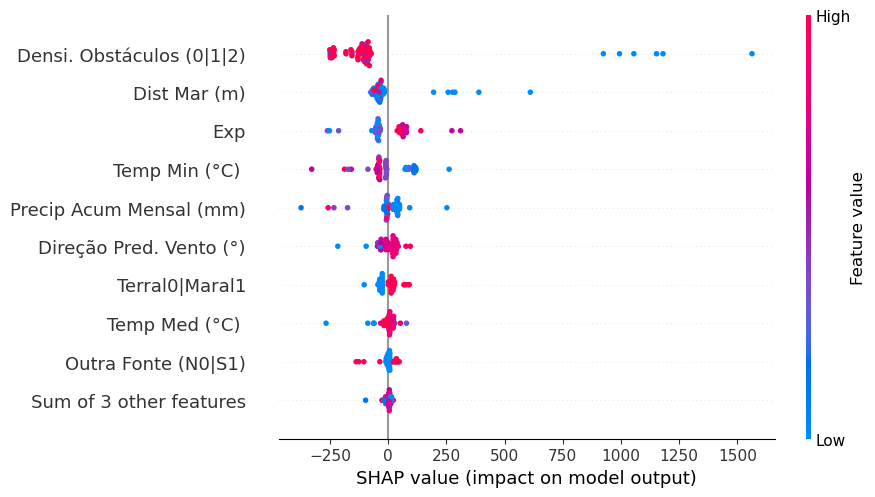

In [70]:
#Explicação do modelo usando a biblioteca Shapley
X_test_df = pd.DataFrame(X_test, columns=cols)
explainer = shap.Explainer(model, X_test_df)
shap_values = explainer(X_test_df)
shap.plots.beeswarm(shap_values)

Qual seria a resposta do modelo caso utlizassemos todas as features?

In [71]:
X=df_cp.iloc[:,:-1]
y=df_cp.iloc[:,-1]
#Padronização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
#Divisão treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
model_full=XGBRegressor(colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8, random_state=42)
model_full.fit(X_train, y_train)
y_pred = model_full.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

MAE: 76.2796
R²: 0.8865


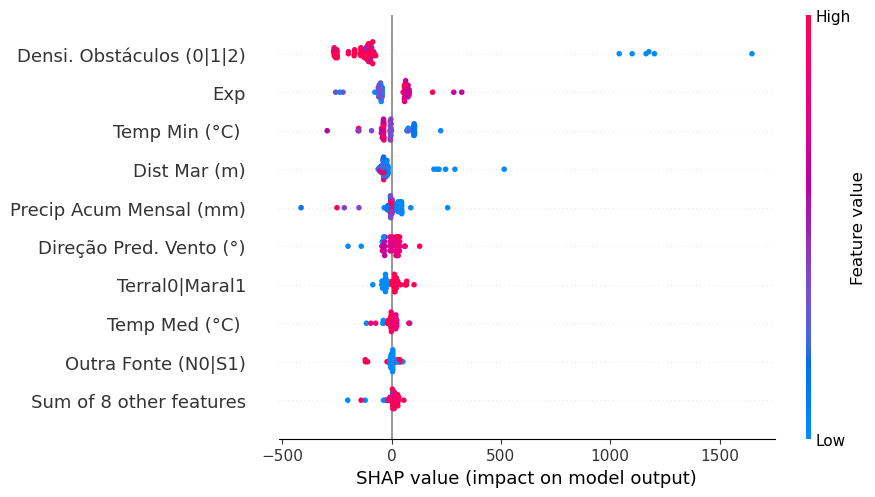

In [73]:
#Explicação do modelo usando a biblioteca Shapley
cols=X.columns
X_test_df = pd.DataFrame(X_test,columns=cols)
explainer = shap.Explainer(model_full, X_test_df)
shap_values = explainer(X_test_df)
shap.plots.beeswarm(shap_values)

O modelo com todas as 20 features (já excluindo os desvios padrão) não apresentou qualquer melhoria em relação ao modelo com as 12 features selecionadas pelo método RFE.